# Getting started with using FeedbackParticleFilters.jl

In [1]:
using FeedbackParticleFilters
using Distributions
using PyPlot

┌ Info: Recompiling stale cache file /Users/simone/.julia/compiled/v1.1/FeedbackParticleFilters/KhkEf.ji for FeedbackParticleFilters [f4440bb6-80da-11e9-1db0-85cc1897f664]
└ @ Base loading.jl:1184


## Setting up a filtering problem

Here, we set up a basic one-dimensional linear-Gaussian continuous-time filtering problem:

$$ dX_t = -X_t dt + \sqrt{2} dW_t, \quad X_0\sim\mathcal{N}(0,1), $$
$$ dY_t = X_t dt + dV_t. $$

In [2]:
state_model = ScalarDiffusionStateModel(x->-x, x->sqrt(2.), Normal())
obs_model = ScalarDiffusionObservationModel(x->x)

filt_prob = ContinuousTimeFilteringProblem(state_model, obs_model);

## Initializing particle ensembles

The following line initializes a feedback particle filter ensemble of size $N=100$ for the scalar diffusion model `state_model` above. 
This means that the individual particles are scalar real numbers, i.e. of type `Float64`. 
The particle positions are randomly initialized from the initial distribution provided in `state_model`.

In [13]:
ensemble = FPFEnsemble(state_model, 100)

FPFEnsemble{Float64}([-1.09341, 0.554669, 0.107143, -0.738177, -0.289542, 0.510505, 0.421214, -1.35027, 0.229313, 0.499798  …  1.43336, -1.17512, -0.563844, 0.317968, -1.8786, 0.119547, -0.17261, 2.31844, -0.196035, 0.191926], 100)

## Computing (estimating) the gain

Once an ensemble is initialized, the FPF gain has to be computed.
The constructor for `GainEquation` (itself an abstract type) constructs an appropriate equation for the provided observation model.

In [14]:
eq = GainEquation(state_model, obs_model, ensemble);

In the case of `obs_model` defined above, this is a scalar Poisson equation:

In [15]:
typeof(eq)

ScalarPoissonEquation

The `ScalarPoissonEquation` object encapsulates the data provided by the models, such as the observation function.
In addition, it contains the fields `potential` and `gain` for the solution of the gain equation and its gradient respectively, at the particle locations.
They are initialized with ones and zeros respectively.

Calling `Solve!` with an appropriate gain estimation method will fill in the `potential` and `gain` fields:

In [36]:
method = SemigroupMethod1d(1E-1, 1E-4, 1000)
@time Solve!(eq, method);

  0.000349 seconds (37 allocations: 171.813 KiB)


The solution may be visualised as follows:

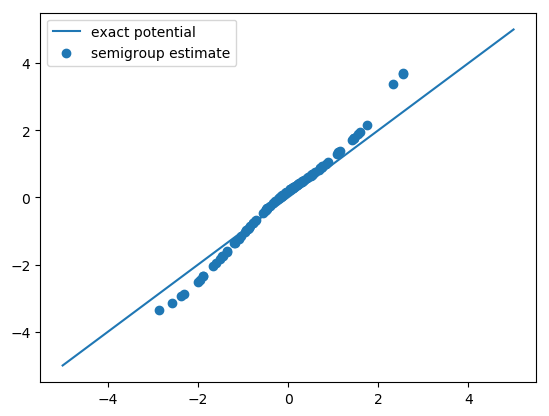

In [37]:
plot([x for x in -5:.1:5], [x for x in -5:.1:5])
scatter(eq.positions, eq.potential);
legend(("exact potential","semigroup estimate"));

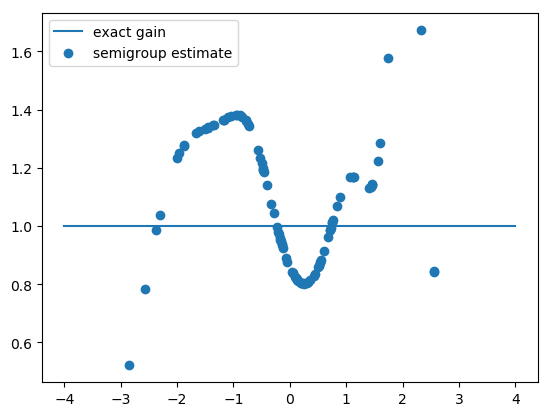

In [38]:
#ylim([0,2])
plot([x for x in -4:.1:4], [1 for x in -4:.1:4])
scatter(eq.positions, eq.gain);
legend(("exact gain","semigroup estimate"));

## Running simulations

Above, we looked at the gain estimation step, which is crucial for FPFs. 
But running a feedback particle filter simulation involves prediction as well as simulation of the hidden state and observation processes.
This is fully implemented in FeedbackParticleFilters.jl.

First, we define the filter to be run.
In this case, we use `N = 100` particles.

In [39]:
filter = FeedbackParticleFilter(filt_prob, method, 100);

Then we set up a simulation for the filter for `n_time = 1000` time steps and a time discretization of `dt = 0.01`.

In [40]:
simulation = FPFSimulation(filter, 1000, 0.01);

Calling `run!` will perform the full simulation.
To monitor progress, a dot is shown every 100 time steps.

In [41]:
@time run!(simulation)

Starting simulation!!!!!!!!!!..!!...!!!!.!!....DONE.
  1.012295 seconds (1.54 M allocations: 339.116 MiB, 3.56% gc time)


### Recording simulation trajectories

Normally, the simulation is run without storing any intermediate values, such as the particle positions for intermediate time steps.
In order to record intermediate values, we can define a custom data type which contains the fields which we wish to store.
Those fields have to be fieldnames of the `FPFSimulation` data structure:

In [42]:
fieldnames(FPFSimulation)

(:n_time, :dt, :propagate!, :emit, :update!, :state, :observation, :ensemble, :eq)

As an example, the following defines a data type that will store the hidden state and the particle ensemble for each time step (the naming does not matter): 

In [68]:
struct record
    state
    ensemble
end

Calling `run!` with an additional parameter equal to the data type just defined will return an array containing all the records:

In [84]:
method = SemigroupMethod1d(1E-1, 1E-2, 10000)
filter = FeedbackParticleFilter(filt_prob, method, 100);
simulation = FPFSimulation(filter, 10000, 0.01);
@time records = run!(simulation, record);

Starting simulation....................................................................................................DONE.
  9.475349 seconds (15.17 M allocations: 3.038 GiB, 8.05% gc time)


In [85]:
typeof(records)

Array{record,1}

We may now visualize the hidden state and filter trajectory:

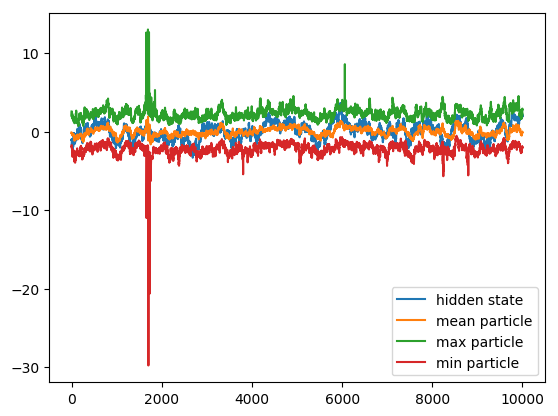

In [86]:
nn = 1:10000
plot([rec.state for rec in records[nn]]);
plot([mean(rec.ensemble.positions) for rec in records[nn]]);
plot([maximum(rec.ensemble.positions) for rec in records[nn]]);
plot([minimum(rec.ensemble.positions) for rec in records[nn]]);
legend(("hidden state","mean particle","max particle","min particle"));

And evaluate the mean-squared error of the particle estimate:

In [118]:
MSE(records)

0.7476857313819346

Or the relative mean-squared error (i.e. normalized by the prior variance):

In [121]:
RelativeMSE(records)

0.6794963145458991

### Recording further simulation details for troubleshooting

Sometimes it may be necessary to record further details about the simulation, for example the gain equation objects for gain estimation, in order to troubleshoot problems with the filtering algorithm.

Here, we include the `eq` field of the simulation in addition to the previous two fields:

In [123]:
mutable struct anotherrecord
    state
    ensemble
    eq
end

In [124]:
method = SemigroupMethod1d(1E-1, 1E-2, 10000)
filter = FeedbackParticleFilter(filt_prob, method, 100);
simulation = FPFSimulation(filter, 1000, 0.01);
@time records = run!(simulation, anotherrecord);

Starting simulation..........DONE.
  1.418067 seconds (1.42 M allocations: 222.616 MiB, 19.90% gc time)


These are the simulated trajectories:

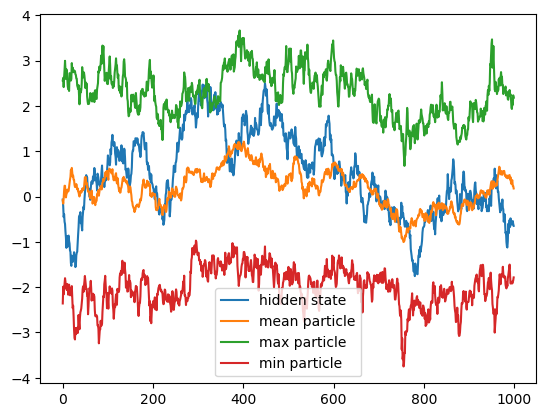

In [125]:
nn = 1:1000
plot([rec.state for rec in records[nn]]);
plot([mean(rec.ensemble.positions) for rec in records[nn]]);
plot([maximum(rec.ensemble.positions) for rec in records[nn]]);
plot([minimum(rec.ensemble.positions) for rec in records[nn]]);
legend(("hidden state","mean particle","max particle","min particle"));

Since we included the `eq` field in the recording, we can now do things such as displaying all the gain estimates at once:

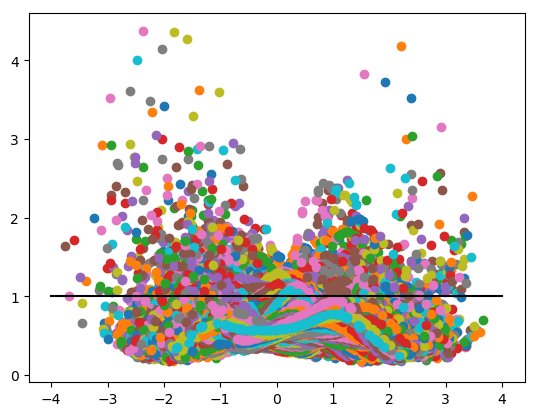

In [129]:
plot([x for x in -4:.1:4], [1 for x in -4:.1:4], color="black")
for i in 1:1000
    scatter(records[i].ensemble.positions, records[i].eq.gain);
end